# Imports

In [1]:
import math
import mimetypes
import os
import PIL
import re
import time
from collections.abc import Iterable
from collections import Counter, OrderedDict
from functools import partial, wraps
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from pathlib import Path

import fastai
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import DataLoader
from fastai.data.external import untar_data, URLs
from fastprogress.fastprogress import format_time, master_bar, progress_bar

/Users/imad/anaconda3/envs/dl/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%load_ext lab_black

In [3]:
torch.__version__

'1.13.1'

In [4]:
fastai.__version__

'2.7.9'

# Data

## Data Loaders

In [5]:
def collate(idxs, ds):
    xb, yb = zip([ds[i] for i in idxs])
    return torch.stack(xb), torch.stack(yb)

In [6]:
class NewDataLoader:
    def __init__(self, dataset, bs=64, shuffle=False, n_workers=1):
        self.dataset = dataset
        self.bs = bs
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.n = len(dataset)

    def __len__(self):
        return ((self.n - 1) // self.bs) + 1

    def __iter__(self):
        idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        chunks = [idxs[i * self.bs : (i + 1) * self.bs] for i in range(len(self))]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, idxs=chunks, ds=self.dataset)

In [7]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return [
        DataLoader(train_ds, bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, bs * 2, shuffle=False, **kwargs),
    ]

In [8]:
class DataBunch:
    def __init__(self, train_dl, valid_dl, c_in, c_out):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.c_in = c_in
        self.c_out = c_out

    @property
    def train_ds(self):
        return self.train_dl.dataset

    @property
    def valid_ds(self):
        return self.valid.dataset

## Utils

In [9]:
def listify(obj):
    if obj is None:
        return []
    elif isinstance(obj, str):
        return [obj]
    elif isinstance(obj, Iterable):
        return list(obj)
    elif isinstance(obj, list):
        return obj
    return [obj]

In [10]:
listify(None), listify(""), listify("test"), listify([1]), listify({"a": 1}), listify(
    (1,)
)

([], [''], ['test'], [1], ['a'], [1])

In [11]:
def setify(obj):
    if isinstance(obj, set):
        return obj
    return set(listify(obj))

In [12]:
setify([1, 1]), setify("imad")

({1}, {'imad'})

In [13]:
def uniqueify(x, sort=False):
    # res = list(setify(x))
    res = list(OrderedDict.fromkeys(x).keys())
    if sort:
        res.sort()
    return res

In [14]:
class ListContainer:
    def __init__(self, items):
        self.items = listify(items)

    def __iter__(self):
        return iter(self.items)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx]

    def __setitem__(self, idx, item):
        self.data[idx] = item

    def __delitem__(self, idx):
        del self.data[idx]

    def __repr__(self):
        res = (
            f"{self.__class__.__name__}: ({len(self.items)} items)\n"
            f"{self.items[:10]}"
        )
        if len(self) > 10:
            res = res[:-1] + ", ...]"
        return res

In [15]:
l = ListContainer(range(20))
l

ListContainer: (20 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...]

In [16]:
def compose(x, funcs, *args, order="_order", **kwargs):
    key = lambda x: getattr(x, order, 0)
    for func in sorted(listify(funcs), key=key):
        x = func(x, *args, **kwargs)
    return x

## Get Files

In [17]:
image_extensions = [k for k, v in mimetypes.types_map.items() if v.startswith("image/")]

In [18]:
def _get_files(path, f_names, extensions=None):
    path = Path(path)
    res = [
        path / f_name
        for f_name in f_names
        if not f_name.startswith(".")
        and ((not extensions) or f".{f_name.split('.')[-1].lower()}" in extensions)
    ]
    return res

In [19]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i, (p, d, fs) in enumerate(os.walk(path)):
            if include is not None and i == 0:
                d[:] = [o for o in d if o in include]
            else:
                d[:] = [o for o in d if not o.startswith(".")]
            res += _get_files(p, fs, extensions)
    else:
        f_names = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f_names, extensions)
    return res

## Item List

In [20]:
class ItemList(ListContainer):
    def __init__(self, items, path=".", tfms=None):
        super().__init__(items)
        self.path = path
        self.tfms = tfms

    def new(self, items, cls=None):
        if cls is None:
            cls = self.__class__
        return cls(items, self.path, self.tfms)

    def get(self, item):
        return item

    def _get(self, item):
        return compose(self.get(item), self.tfms)

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list):
            return [self._get(item) for item in res]
        return self._get(res)

    def __repr__(self):
        return super().__repr__() + f"\nPath: {self.path}"

## Image List

In [21]:
class ImageList(ItemList):
    @classmethod
    def from_files(
        cls, path, extensions=image_extensions, recurse=True, include=None, **kwargs
    ):
        return cls(get_files(path, extensions, recurse, include), **kwargs)

    def get(self, item):
        return PIL.Image.open(item)

In [22]:
class Transform:
    _order = 0

In [23]:
class MakeRGB(Transform):
    def __call__(self, item):
        return item.convert("RGB")

In [24]:
class ResizeFixed(Transform):
    _order = 10

    def __init__(self, size):
        if isinstance(size, int):
            size = (size, size)
        self.size = size

    def __call__(self, item):
        return item.resize(self.size, PIL.Image.Resampling.BILINEAR)


def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h, w, -1).permute(2, 0, 1)


to_byte_tensor._order = 20


def to_float_tensor(item):
    return item.float().div_(255.0)


to_float_tensor._order = 20

## Text List

In [25]:
def read_file(f_name):
    with open(f_name, "r", encoding="utf8") as f:
        return f.read()

In [26]:
class TextList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=".txt", recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse, include), path, **kwargs)

    def get(self, i):
        if isinstance(i, Path):
            return read_file(i)
        return i

## Split Data

In [27]:
def grandparent_splitter(f_name, train_name="train", valid_name="valid"):
    gp = f_name.parent.parent.name
    if gp == valid_name:
        return True
    elif gp == train_name:
        return False
    return

In [28]:
def random_splitter(f_name, p_valid=0.2):
    return np.random.random() < p_valid

In [29]:
def split_by_func(items, func):
    mask = [func(item) for item in items]
    train = [item for item, m in zip(items, mask) if m is False]
    valid = [item for item, m in zip(items, mask) if m]
    return train, valid

In [30]:
class SplitData:
    def __init__(self, train, valid):
        self.train = train
        self.valid = valid

    def __getattr__(self, k):
        return getattr(self.train, k)

    def __setstate__(self, data):
        self.__dict__.update(data)

    @classmethod
    def split_by_func(cls, item_list, func):
        lists = map(item_list.new, split_by_func(item_list.items, func))
        return cls(*lists)

    def to_databunch(self, bs, c_in, c_out, **kwargs):
        dls = get_dls(self.train, self.valid, bs, **kwargs)
        return DataBunch(*dls, c_in=c_in, c_out=c_out)

    def __repr__(self):
        return f"{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n"

## Processors

In [31]:
class Processor:
    def process(self, item):
        return item

In [32]:
class CategoryProcessor(Processor):
    def __init__(self):
        self.vocab = None

    def __call__(self, items):
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi = {k: v for v, k in enumerate(self.vocab)}
        return [self.process(item) for item in items]

    def process(self, item):
        return self.otoi[item]

    def _deprocess(self, idx):
        self.vocab[idx]

    def deprocess(self, idxs):
        return [self.vocab[idx] for i in idxs]

## Labeled Data

In [33]:
def parnet_labeler(f_name):
    return f_name.parent.name

In [34]:
def _label_by_func(dataset, func, cls=ItemList):
    return cls([func(f_name) for f_name in dataset.items], path=dataset.path)

In [35]:
class LabeledData:
    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x = self.process(x, proc_x)
        self.y = self.process(y, proc_y)
        self.proc_x = proc_x
        self.proc_y = proc_y

    def process(self, il, proc):
        return il.new(compose(il.items, proc))

    def __repr__(self):
        return f"{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n"

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (
            isinstance(idx, torch.LongTensor) and not idx.ndim
        )
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deprocess(item) if isint else proc._deprocess(item)
        return item

    def x_obj(self, idx):
        return self.obj(self.x, idx, self.proc_x)

    def y_obj(self, idx):
        return self.obj(self.y, idx, self.proc_y)

    @classmethod
    def label_by_func(cls, il, func, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, func), proc_x, proc_y)

In [36]:
def label_by_func(splitted_data, func, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(splitted_data.train, func, proc_x, proc_y)
    valid = LabeledData.label_by_func(splitted_data.valid, func, proc_x, proc_y)
    return SplitData(train, valid)

# Annealing

In [37]:
def annealer(func):
    wraps(func)

    def annealer_wrapper(*args, **kwargs):
        return partial(func, *args)

    return annealer_wrapper


@annealer
def no_sched(start, end, pos):
    return start


@annealer
def lin_sched(start, end, pos):
    return start + (end - start) * pos


@annealer
def cos_sched(start, end, pos):
    return start + (1 + math.cos(math.pi * (1 - pos))) * (end - start) / 2


@annealer
def exp_sched(start, end, pos):
    return start * (end / start) ** pos


def cos_1cycle_anneal(start, high, end):
    return [cos_sched(start, high), cos_sched(high, end)]


def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.0
    pcts = torch.tensor([0] + listify(pcts))
    assert (pcts >= 0).all()
    pcts = torch.cumsum(pcts, 0)

    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos - pcts[idx]) / (pcts[idx + 1] - pcts[idx])
        return scheds[idx](actual_pos)

    return _inner

# Callbacks

In [38]:
class Callback:
    _order = 0

    def set_learner(self, learner):
        self.learner = learner

    def __getattr__(self, k):
        return getattr(self.learner, k)

    @property
    def name(self):
        """
        Returns the name of the callback after removing the word `callback`
        and then convert it to snake (split words by underscores).
        """
        name = re.sub(r"Callback$", "", self.__class__.__name__)
        return Callback.camel2snake(name or "callback")

    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        # if f and f():
        #     return True
        # return False
        if f is not None:
            f()

    @staticmethod
    def camel2snake(name):
        """
        Convert name of callback by inserting underscores between small and capital
        letters. For example, `TestCallback` becomes `test_callback`.
        """
        pattern1 = re.compile("(.)([A-Z][a-z]+)")
        pattern2 = re.compile("([a-z0-9])([A-Z])")
        name = re.sub(pattern1, r"\1_\2", name)
        return re.sub(pattern2, r"\1_\2", name).lower()

## TrainEval

In [39]:
class TrainEvalCallback(Callback):
    """
    Tracks the number of iterations and epoch done and set training and eval
    modes.
    """

    _order = -10

    def before_fit(self):
        self.learner.n_iters = 0
        self.learner.pct_train = 0

    def after_batch(self):
        if self.learner.training:
            self.learner.n_iters += 1
            # Assuming here that all batches are of the same size
            # Otherwise, self.iters * self.n_epochs would be smaller
            # for the last batch
            self.learner.pct_train += 1 / (self.iters * self.n_epochs)

    def before_train(self):
        self.model.train()
        self.learner.training = True
        self.learner.pct_train = self.epoch / self.n_epochs

    def before_validate(self):
        self.model.eval()
        self.learner.training = False

## Average Stats

In [40]:
class AvgStats:
    def __init__(self, metrics, training=True):
        self.metrics = listify(metrics)
        self.training = training

    def reset(self):
        self.tot_loss = 0
        self.count = 0
        self.tot_metrics = [0.0] * len(self.metrics)

    @property
    def all_stats(self):
        """Returns a list of both loss and metrics."""
        return [self.tot_loss.item()] + self.tot_metrics

    @property
    def avg_stats(self):
        """Returns the average of loss/metrics."""
        return [o / self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count:
            return ""
        return f"{'train' if self.training else 'valid'}: {self.avg_stats}"

    def accumulate(self, learner):
        """Evaluate metrics and accumulate them to at the epoch level."""
        bs = learner.xb.shape[0]
        self.count += bs
        self.tot_loss += learner.loss * bs
        for i, metric in enumerate(self.metrics):
            self.tot_metrics[i] += metric(learner.pred, learner.yb) * bs

In [41]:
class AvgStatsCallback(Callback):
    _order = -10

    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def before_fit(self):
        metrics_names = ["loss"] + [
            metric.__name__ for metric in self.train_stats.metrics
        ]
        names = (
            ["epoch"]
            + [f"train_{name}" for name in metrics_names]
            + [f"valid_{name}" for name in metrics_names]
            + ["time"]
        )
        self.logger(names)

    def before_epoch(self):
        """Reset metrics/loss."""
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()

    def after_loss(self):
        """Evaluate metrics and accumulate them."""
        stats = self.train_stats if self.training else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.learner)

    def after_epoch(self):
        stats = [str(self.epoch)]
        for o in [self.train_stats, self.valid_stats]:
            stats += [f"{v:.6f}" for v in o.avg_stats]
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

## Progress Callback

In [42]:
class ProgressCallback(Callback):
    """Add progress bar as logger for tracking metrics."""

    _order = -20

    def before_fit(self):
        self.mbar = master_bar(range(self.learner.n_epochs))
        self.mbar.on_iter_begin()
        # Overwrite default learner logger
        self.learner.logger = partial(self.mbar.write, table=True)

    def after_fit(self):
        self.mbar.on_iter_end()

    def after_batch(self):
        self.pb.update(self.learner.iter)

    def before_train(self):
        self.set_pb()

    def before_validate(self):
        self.set_pb()

    def set_pb(self):
        self.pb = progress_bar(self.learner.dl, parent=self.mbar)
        self.mbar.update(self.epoch)

## Cuda

In [43]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device

    def before_fit(self):
        self.learner.model.to(self.device)

    def before_batch(self):
        self.learner.xb = self.learner.xb.to(self.device)
        self.learner.yb = self.learner.yb.to(self.device)

## Recorder

In [44]:
class Recorder(Callback):
    _order = 50

    def before_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if self.training:
            for pg, lr in zip(self.opt.param_groups, self.lrs):
                lr.append(pg["lr"])
            self.losses.append(self.loss.detach().cpu())

    def plot_lr(self, pgid=-1):
        """
        Plot learning rates in the parameter group id `pgid`, default to the last parameter group.
        """
        plt.plot(self.lrs[pgid])

    def plot_loss(self, skip_last=0):
        """
        Plot losses, optionally skip last `skip_last` losses.
        """
        n = len(self.losses) - skip_last
        plt.plot(self.losses[:n])

    def plot(self, skip_last=0, pgid=-1):
        """
        Plot both losses and learning rates.
        """
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale("log")
        plt.plot(lrs[:n], losses[:n])

## Parameter Scheduler

In [45]:
class ParamScheduler(Callback):
    _order = 60

    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = sched_funcs

    def before_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert_msg = (
            f"Number of schedulers should match number of parameter groups, "
            f"{print(len(self.opt.param_groups), len(self.sched_funcs))}"
        )
        assert len(self.opt.param_groups) == len(self.sched_funcs), assert_msg
        for pg, sched_func in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = sched_func(self.pct_train)

    def before_batch(self):
        if self.training:
            self.set_param()

## Learning Rate Finder

In [46]:
class LR_Finder(Callback):
    _order = 60

    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9

    def before_batch(self):
        if not self.training:
            return
        pos = self.n_iters / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.param_groups:
            pg["lr"] = lr

    def after_step(self):
        if self.n_iters >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelFitException()
        elif self.loss < self.best_loss:
            self.best_loss = self.loss

## Mixup

In [47]:
class NoneReduce:
    def __init__(self, loss_func):
        self.loss_func = loss_func
        self.old_reduction = None

    def __enter__(self):
        if hasattr(self.loss_func, "reduction"):
            self.old_reduction = getattr(self.loss_func, "reduction")
            setattr(self.loss_func, "reduction", "none")
            return self.loss_func
        else:
            return partial(self.loss_func, reduction="none")

    def __exit__(self, exc_type, exc_val, traceback):
        if self.old_reduction is not None:
            setattr(self.loss_func, "reduction", self.old_reduction)

In [48]:
def reduce_loss(loss, reduction=None):
    return (
        loss.mean()
        if reduction == "mean"
        else loss.sum()
        if reduction == "sum"
        else loss
    )

In [49]:
class Mixup(Callback):
    _order = 90

    def __init__(self, alpha=0.4):
        self.distrib = torch.distributions.beta.Beta(
            torch.tensor([alpha]), torch.tensor([alpha])
        )

    def before_fit(self):
        self.learner.loss_func, self.old_loss_func = (
            self.loss_func,
            self.learner.loss_func,
        )

    def after_fit(self):
        self.learner.loss_func = self.old_loss_func

    def before_batch(self):
        λ = self.distrib.sample((len(self.learner.xb),)).to(self.learner.xb.device)
        λ = torch.stack([λ, 1 - λ], dim=1)
        self.λ = λ.max(1)[0].view(-1, 1, 1, 1)
        shuffle = torch.randperm(len(self.learner.xb))
        self.learner.xb = self.learner.xb * self.λ + self.learner.xb[shuffle] * (
            1 - self.λ
        )
        self.yb1 = self.learner.yb[shuffle]

    def loss_func(self, pred, yb):
        if not self.training:
            return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, self.yb)
            loss2 = loss_func(pred, self.yb1)
        loss = loss1 * self.λ + loss2 * (1 - self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, "reduction", "mean"))

## Batch TransformX

In [50]:
class BatchTransformXCallback(Callback):
    _order = 2

    def __init__(self, tfm):
        self.tfm = tfm

    def before_batch(self):
        self.learner.xb = self.tfm(self.learner.xb)

## Model Resetter

In [51]:
class ModelResetter(Callback):
    def before_train(self):
        self.model.reset()

    def before_validate(self):
        self.model.reset()

    def after_fit(self):
        self.model.reset()

# Learner

Basic class handling tweaks of the training loop by changing a [Learner](https://dev.fast.ai/13a_learner#Learner) in various events.

The training loop consists of a minimal set of instructions; looping through the data we:
- compute the output of the model from the input
- calculate a loss between this output and the desired target
- compute the gradients of this loss with respect to all the model parameters
- update the parameters accordingly
- zero all the gradients

Any tweak of this training loop is defined in a [Callback](https://dev.fast.ai/callback.core#Callback) to avoid over-complicating the code of the training loop, and to make it easy to mix and match different techniques (since they'll be defined in different callbacks). A callback can implement actions on the following events:
1. `before_fit`: called before doing anything, ideal for initial setup
1. `before_epoch`: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch
1. `before_train`: called at the beginning of the training part of an epoch
1. `before_batch`: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance)
1. `after_pred`: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss
1. `after_loss`: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance)
1. `after_backward`: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance)
1. `after_step`: called after the step and before the gradients are zeroed
1. `after_cancel_batch`: reached immediately after a `CancelBatchException` before proceeding to `after_batch`
1. `after_batch`: called at the end of a batch, for any clean-up before the next one
1. `after_cancel_train`: reached immediately after a `CancelTrainException` before proceeding to `after_train`
1. `after_train`: called at the end of the training phase of an epoch
1. `before_validate`: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation
1. `after_cancel_validate`: reached immediately after a `CancelValidateException` before proceeding to `after_validate`
1. `after_validate`: called at the end of the validation part of an epoch
1. `after_cancel_epoch`: reached immediately after a `CancelEpochException` before proceeding to `after_epoch`
1. `after_epoch`: called at the end of an epoch, for any clean-up before the next one
1. `after_cancel_fit`: reached immediately after a `CancelFitException` before proceeding to `after_fit`
1. `after_fit`: called at the end of training, for final clean-up

In [52]:
class CancelFitException(Exception):
    """Stop training and exit"""


class CancelEpochException(Exception):
    """Stop current epoch and move to next epoch."""


class CancelTrainException(Exception):
    """Stop training current batch and move to validation."""


class CancelValidException(Exception):
    """Stop validation phase and move to next epoch"""


class CancelBatchException(Exception):
    """Stop current batch and move to next batch."""

In [53]:
def params_getter(model):
    return model.parameters()

In [54]:
class Learner:
    ALL_CBS: set[str] = {
        "before_fit",
        "before_epoch",
        "before_train",
        "before_validate",
        "before_batch",
        "after_pred",
        "after_loss",
        "after_backward",
        "after_step",
        "after_cancel_batch",
        "after_batch",
        "after_cancel_train",
        "after_train",
        "after_cancel_validate",
        "after_validate",
        "after_cancel_epoch",
        "after_epoch",
        "after_cancel_fit",
        "after_fit",
    }

    def __init__(
        self,
        model,
        data,
        loss_func,
        opt_func,
        lr=1e-2,
        splitter=params_getter,
        cbs=None,
        cb_funcs=None,
    ):
        """
        Learner is a basic class that handles training loop of pytorch model and utilize a systems of callbacks that makes training loop very customizable and extensible. You just need to provide a
        """
        self.model = model
        self.data = data
        self.loss_func = loss_func
        self.opt_func = opt_func
        self.lr = lr
        self.splitter = splitter
        self.opt, self.training = None, False
        # We can customize it & use progress bar or log to a file
        self.logger = print

        # Callbacks
        self.cbs = []
        # self.add_cb(TrainEvalCallback())
        # self.add_cb(ProgressCallback())
        # self.add_cb(Recorder())
        # Add default useful callbacks
        self.add_cbs([TrainEvalCallback(), ProgressCallback(), Recorder()])
        self.add_cbs(cbs)
        self.add_cbs(cb_func() for cb_func in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in setify(cbs):
            self.add_cb(cb)

    def add_cb(self, cb):
        cb.set_learner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in cbs:
            self.cbs.remove(cb)

    def _one_batch(self, i, xb, yb):
        self.iter = i
        self.xb, self.yb = xb, yb
        try:
            self("before_batch")
            self.pred = self.model(self.xb)
            self("after_pred")
            self.loss = self.loss_func(self.pred, self.yb)
            self("after_loss")
            if self.training:
                self.loss.backward()
                self("after_backward")
                self.opt.step()
                self("after_step")
                self.opt.zero_grad()
        except CancelBatchException:
            self("after_cancel_batch")
        finally:
            self("after_batch")

    def _all_batches(self, dl):
        self.iters = len(dl)
        for i, (xb, yb) in enumerate(dl):
            self._one_batch(i, xb, yb)

    def fit(self, epochs, cbs=None, reset_opt=False):
        cbs = listify(cbs)
        self.add_cbs(cbs)
        if reset_opt or not self.opt:
            self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        self.n_epochs = epochs
        self.loss = torch.tensor(0.0)
        try:
            self("before_fit")
            for epoch in range(self.n_epochs):
                try:
                    self.epoch = epoch
                    self.dl = self.data.train_dl
                    self("before_epoch")

                    try:
                        self("before_train")
                        self._all_batches(self.data.train_dl)
                    except CancelTrainException:
                        self("after_cancel_train")
                    finally:
                        self("after_train")

                    try:
                        self.dl = self.data.valid_dl
                        self("before_validate")
                        with torch.no_grad():
                            self._all_batches(self.data.valid_dl)
                    except CancelValidException:
                        self("after_cancel_validate")
                    finally:
                        self("after_validate")
                except CancelEpochException:
                    self("after_cancel_epoch")
                finally:
                    self("after_epoch")
        except CancelFitException:
            self("after_cancel_fit")
        finally:
            self("after_fit")
            # self.remove_cbs(cbs)

    def __call__(self, cb_name):
        assert cb_name in Learner.ALL_CBS, f"{cb_name} isn't a valid callback name"
        # res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            # res = cb(cb_name) and res
            cb(cb_name)
        # return res

# Modeling Utils

In [55]:
def lin_comb(x, y, alpha):
    return alpha * x + (1 - alpha) * y

In [56]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak = leak
        self.sub = sub
        self.maxv = maxv

    def forward(self, x):
        x = F.leaky_relu(x, leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_()
        return x

In [57]:
def conv_layer(ni, nf, ks, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride), GeneralRelu(**kwargs)
    )

In [58]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [59]:
def flatten(x):
    return x.view(x.shape[0], -1)

In [60]:
conv_layer(3, 32, 3, leak=True)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): GeneralRelu()
)

In [61]:
def prev_pow_2(x):
    return 2 ** math.floor(math.log2(x))


def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2):
        return layer(ni, nf, 3, stride=stride, **kwargs)

    l1 = data.c_in
    l2 = prev_pow_2(l1 * 3 * 3)
    layers = [f(l1, l2, stride=1), f(l2, l2 * 2, stride=2), f(l2 * 2, l2 * 4, stride=2)]
    nfs = [l2 * 4] + nfs
    layers += [f(nfs[i], nfs[i + 1]) for i in range(len(nfs) - 1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c_out)]
    return layers

In [62]:
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [63]:
def get_learner(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [64]:
def init_cnn(model, uniform=False):
    initializer = nn.init.kaiming_uniform_ if uniform else nn.init.kaiming_normal_
    for module in model:
        if isinstance(module, nn.Sequential):
            initializer(module[0].weight.data)
            module[0].bias.data.zero_()

In [65]:
def accuracy(pred, target):
    return (pred.argmax(dim=1) == target).float().mean()

In [66]:
def cross_entropy_flat(input, target):
    bs, sl = target.size()
    return F.cross_entropy(input.view(bs * sl, -1), target.view(bs * sl))


def accuracy_flat(input, target):
    bs, sl = target.size()
    return accuracy(input.view(bs * sl, -1), target.view(bs * sl))

# Training

In [67]:
img_net_path = untar_data(URLs.IMAGENETTE_160)

In [68]:
!ls {img_net_path}

noisy_imagenette.csv train                val


In [69]:
img_net_path

Path('/Users/imad/.fastai/data/imagenette2-160')

In [153]:
# Prepare Data
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
image_list = ImageList.from_files(img_net_path, tfms=tfms)
splitted_data = SplitData.split_by_func(
    image_list,
    partial(grandparent_splitter, train_name="train", valid_name="val"),
)
labeled_data = label_by_func(
    splitted_data, parnet_labeler, proc_y=[CategoryProcessor()]
)
data = labeled_data.to_databunch(128, c_in=3, c_out=10, num_workers=4)

In [155]:
splitted_data

SplitData
Train: ImageList: (9469 items)
[Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]
Path: .
Valid: ImageList: (3925 items)
[Path('/Users/imad/.fastai/data/imagen

In [156]:
labeled_data

SplitData
Train: LabeledData
x: ImageList: (9469 items)
[Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]
Path: .
y: ItemList: (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [76]:
batch = next(iter(data.train_dl))
batch[0].shape, batch[1].shape

(torch.Size([128, 3, 128, 128]), torch.Size([128]))

In [77]:
def normalize(x, mean, std):
    return (x - mean[..., None, None]) / std[..., None, None]


img_net_mean = torch.tensor([0.47, 0.48, 0.45])
img_net_std = torch.tensor([0.29, 0.28, 0.3])
norm_img_net = partial(normalize, mean=img_net_mean, std=img_net_std)

In [78]:
sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.1, 0.3, 0.05))

In [114]:
cbs = [
    partial(BatchTransformXCallback, norm_img_net)(),
    # ParamScheduler("lr", sched),
    AvgStatsCallback(accuracy),
]

In [115]:
nfs = [64, 64, 128, 256]

In [116]:
model = nn.Sequential(*get_cnn_layers(data, nfs, conv_layer))
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (6): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (7): AdaptiveAvgPool2d(output_size=1)
  (8): Lambda()
  (9): Linear(in_features=256, out_features=10, bias=True)
)

In [117]:
init_cnn(model)

In [121]:
learner = Learner(model, data, F.cross_entropy, opt.SGD, lr=0.2, cbs=cbs)

In [122]:
learner.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.236183,0.186609,2.210573,0.202038,01:18


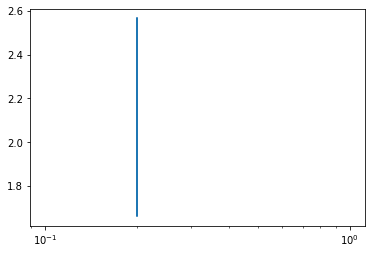

In [105]:
learner.recorder.plot()

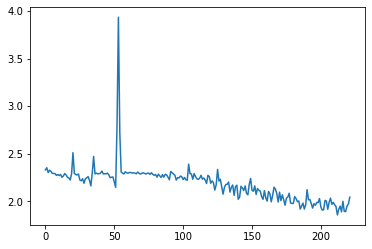

In [123]:
learner.recorder.plot_loss()

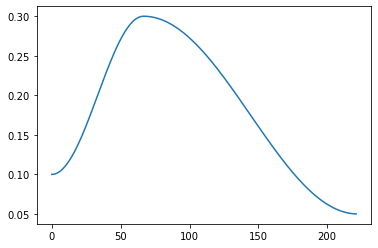

In [124]:
learner.recorder.plot_lr()

In [125]:
params = list(learner.model.parameters())

# Optimizer

## Optimizers

In [373]:
class ParamScheduler(Callback):
    _order = 60

    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = sched_funcs

    def before_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs), print(
            len(self.opt.param_groups), len(self.sched_funcs)
        )
        for hyper_param, f in zip(self.opt.hyper_params, self.sched_funcs):
            hyper_param[self.pname] = f(self.pct_train)

    def before_batch(self):
        if self.training:
            self.set_param()

In [374]:
class Recorder(Callback):
    _order = 50

    def before_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.training:
            return
        for hyper_param, lr in zip(self.opt.hyper_params, self.lrs):
            lr.append(hyper_param["lr"])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self, pgid=-1):
        plt.plot(self.lrs[pgid])

    def plot_loss(self, skip_last=0):
        n = len(self.losses) - skip_last
        plt.plot(self.losses[:n])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale("log")
        plt.plot(lrs[:n], losses[:n])

In [375]:
class SimpleOptimizer:
    def __init__(self, parameters, steppers, **hyper_params):
        self.param_groups = listify(parameters)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hyper_params = [{**hyper_params} for pg in self.param_groups]
        self.steppers = listify(steppers)

    def get_params(self):
        return [
            (p, hp)
            for pg, hp in zip(self.param_groups, self.hyper_params)
            for p in pg
            if p.grad is not None
        ]

    def step(self):
        for p, hp in self.get_params():
            compose(p, self.steppers, **hp)

    def zero_grad(self):
        for p, hp in self.get_params():
            p.grad.detach_()
            p.grad.zero_()

In [376]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)

In [377]:
def get_defaults(stepper):
    return getattr(stepper, "_defaults", {})

In [378]:
def maybe_update(steppers, defaults, func=get_defaults):
    for stepper in steppers:
        for k, v in func(stepper).items():
            if k not in defaults:
                defaults[k] = v

In [379]:
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)


l2_reg._defaults = {"wd": 0}

In [192]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr * wd)


weight_decay._defaults = {"wd": 0}

In [193]:
class Optimizer:
    def __init__(self, parameters, steppers, **hyper_params):
        self.param_groups = listify(parameters)
        self.steppers = listify(steppers)
        maybe_update(self.steppers, hyper_params, get_defaults)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hyper_params = [{**hyper_params} for pg in self.param_groups]

    def get_params(self):
        return [
            (p, hp)
            for pg, hp in zip(self.param_groups, self.hyper_params)
            for p in pg
            if p.grad is not None
        ]

    def step(self):
        for p, hp in self.get_params():
            compose(p, self.steppers, **hp)

    def zero_grad(self):
        for p, hp in self.get_params():
            p.grad.detach_()
            p.grad.zero_()

In [194]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **hyper_params):
        self.stats = listify(stats)
        maybe_update(self.stats, hyper_params, get_defaults)
        super().__init__(params, steppers, **hyper_params)
        self.state = {}

    def step(self):
        for param, hyper_param in self.get_params():
            if param not in self.state:
                self.state[param] = {}
                maybe_update(
                    self.stats, self.state[param], lambda stat: stat.init_state(param)
                )
            state = self.state[param]
            for stat in self.stats:
                state = stat.update_state(param, state, **hyper_param)
            compose(param, self.steppers, **state, **hyper_param)
            self.state[param] = state

In [195]:
class Stat:
    """Initialize and update state of gradients."""

    _defaults = {}

    def init_state(self, p):
        raise NotImplementedError

    def update_state(self, p, state, **kwargs):
        raise NotImplementedError

In [209]:
class AvgGrad(Stat):
    _defaults = {"mom": 0.9}

    def __init__(self, dampening: bool = True):
        self.dampening = dampening

    def init_state(self, p):
        return {"avg_grad": torch.zeros_like(p.grad.data)}

    def update_state(self, p, state, mom, **kwargs):
        state["avg_grad"].mul_(mom).add_(
            1 - mom if self.dampening else 1.0, p.grad.data
        )
        return state

In [254]:
class AvgSqrGrad(Stat):
    _defaults = {"sqr_mom": 0.99}

    def __init__(self, dampening: bool = True):
        self.dampening = dampening

    def init_state(self, p):
        return {"avg_sqr_grad": torch.zeros_like(p.grad.data)}

    def update_state(self, p, state, sqr_mom, **kwargs):
        state["avg_sqr_grad"].mul_(sqr_mom).add_(
            1 - sqr_mom if self.dampening else 1.0, p.grad.data**2
        )
        return state

In [265]:
class StepCount(Stat):
    def init_state(self, p):
        return {"step": 0}

    def update_state(self, p, state, **kwargs):
        state["step"] += 1
        return state

In [255]:
def momentum_step(p, lr, avg_grad, **kwargs):
    p.data.add_(-lr, avg_grad)
    return p

In [273]:
def rmsprop_step(p, lr, avg_sqr_grad, eps, **kwargs):
    p.data.addcdiv_(-lr, p.grad.data, avg_sqr_grad.sqrt() + eps)
    return p


rmsprop_step._defaults = {"eps": 1e-8}

In [287]:
def adam_step(p, lr, mom, sqr_mom, step, avg_grad, avg_sqr_grad, eps, **kwargs):
    debiased_avg_grad = avg_grad / (1 - mom**step)
    debiased_sqr_grad = avg_sqr_grad / (1 - sqr_mom**step)
    p.data.addcdiv_(-lr, debiased_avg_grad, debiased_sqr_grad.sqrt() + eps)
    return p


adam_step._defaults = {"eps": 1e-5}

# Mixup & Label Smoothing

In [407]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε: float = 0.1, reduction="mean"):
        super().__init__()
        self.ε, self.reduction = ε, reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss / c, nll, self.ε)

In [415]:
model = nn.Sequential(*get_cnn_layers(data, nfs, conv_layer))

In [416]:
init_cnn(model)

In [417]:
opt_func = partial(
    StatefulOptimizer, steppers=[momentum_step, weight_decay], stats=AvgGrad()
)

In [418]:
cbs = [
    partial(BatchTransformXCallback, norm_img_net)(),
    ParamScheduler("lr", sched),
    AvgStatsCallback(accuracy),
    Mixup(),
]

In [419]:
learner = Learner(
    model,
    data,
    # F.cross_entropy,
    LabelSmoothingCrossEntropy(),
    opt_func,
    cbs=cbs,
)

In [420]:
learner.fit(10)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.237680,0.181751,2.042526,0.301405,01:30
1,2.092925,0.309008,1.857925,0.402471,01:30
2,2.003995,0.380505,1.801176,0.454008,01:32
3,1.936999,0.429296,1.662507,0.509769,01:31
4,1.860109,0.486218,1.511198,0.605766,01:35
5,1.792441,0.527616,1.439043,0.635970,01:34
6,1.741064,0.565846,1.379478,0.663639,01:33
7,1.680167,0.610941,1.330328,0.693843,01:33
8,1.651475,0.625937,1.246852,0.728482,01:33
9,1.604683,0.649699,1.228974,0.748970,01:46


# NLP

In [145]:
TextList.from_files(Path("tmp/"))

TextList: (9 items)
[Path('tmp/imad.txt'), Path('tmp/test/h.txt'), Path('tmp/test/e.txt'), Path('tmp/test/f.txt'), Path('tmp/test/g.txt'), Path('tmp/train/c.txt'), Path('tmp/train/b.txt'), Path('tmp/train/a.txt'), Path('tmp/train/d.txt')]
Path: tmp

In [143]:
!tree tmp/

tmp/
├── imad.txt
├── test
│   ├── e.txt
│   ├── f.txt
│   ├── g.txt
│   └── h.txt
└── train
    ├── a.txt
    ├── b.txt
    ├── c.txt
    └── d.txt

2 directories, 9 files


In [131]:
path = untar_data(URLs.IMDB)
path

Path('/Users/imad/.fastai/data/imdb')

In [132]:
!ls {path}

README     imdb.vocab test       tmp_clas   tmp_lm     train      unsup


In [133]:
text_list = TextList.from_files(path, include=["train", "test", "unsup"])
text_list

TextList: (100000 items)
[Path('/Users/imad/.fastai/data/imdb/test/neg/1821_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/9487_1.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/4604_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/2828_2.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/10890_1.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/3351_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/8070_2.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/1027_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/8248_3.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/4290_4.txt')...]
Path: /Users/imad/.fastai/data/imdb

In [703]:
text_list[0]

"Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertaining performances by Rickman, Thompson, and Holbrook."

In [704]:
text_splitted = SplitData.split_by_func(
    text_list, partial(random_splitter, p_valid=0.1)
)
text_splitted

SplitData
Train: TextList: (89848 items)
[Path('/Users/imad/.fastai/data/imdb/test/neg/1821_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/4604_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/2828_2.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/10890_1.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/3351_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/8070_2.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/1027_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/8248_3.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/4290_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/10096_1.txt')...]
Path: /Users/imad/.fastai/data/imdb
Valid: TextList: (10152 items)
[Path('/Users/imad/.fastai/data/imdb/test/neg/9487_1.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/3703_2.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/5129_4.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/671_3.txt'), Path('/Users/imad/.fastai/data/imdb/test/neg/3583_3.txt'), P

## Language Model From Scratch

In [953]:
path = untar_data(URLs.HUMAN_NUMBERS)
path

Path('/Users/imad/.fastai/data/human_numbers')

In [954]:
!ls {path}

train.txt valid.txt


In [955]:
!wc -l {path / "*.txt"}

    7999 /Users/imad/.fastai/data/human_numbers/train.txt
    1999 /Users/imad/.fastai/data/human_numbers/valid.txt
    9998 total


In [956]:
lines = []
with open(path / "train.txt", "r") as f:
    lines += f.readlines()
with open(path / "valid.txt", "r") as f:
    lines += f.readlines()

len(lines)

9998

In [957]:
lines[:10]

['one \n',
 'two \n',
 'three \n',
 'four \n',
 'five \n',
 'six \n',
 'seven \n',
 'eight \n',
 'nine \n',
 'ten \n']

In [795]:
text = " . ".join([line.strip() for line in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [958]:
tokens = text.split()
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [962]:
vocab = uniqueify(tokens)
vocab_sz = len(vocab)
word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_to_index

{'one': 0,
 '.': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'ten': 10,
 'eleven': 11,
 'twelve': 12,
 'thirteen': 13,
 'fourteen': 14,
 'fifteen': 15,
 'sixteen': 16,
 'seventeen': 17,
 'eighteen': 18,
 'nineteen': 19,
 'twenty': 20,
 'thirty': 21,
 'forty': 22,
 'fifty': 23,
 'sixty': 24,
 'seventy': 25,
 'eighty': 26,
 'ninety': 27,
 'hundred': 28,
 'thousand': 29}

In [963]:
index_to_word

{0: 'one',
 1: '.',
 2: 'two',
 3: 'three',
 4: 'four',
 5: 'five',
 6: 'six',
 7: 'seven',
 8: 'eight',
 9: 'nine',
 10: 'ten',
 11: 'eleven',
 12: 'twelve',
 13: 'thirteen',
 14: 'fourteen',
 15: 'fifteen',
 16: 'sixteen',
 17: 'seventeen',
 18: 'eighteen',
 19: 'nineteen',
 20: 'twenty',
 21: 'thirty',
 22: 'forty',
 23: 'fifty',
 24: 'sixty',
 25: 'seventy',
 26: 'eighty',
 27: 'ninety',
 28: 'hundred',
 29: 'thousand'}

In [964]:
numericalized = [word_to_index[w] for w in tokens]
numericalized[:10]

[0, 1, 2, 1, 3, 1, 4, 1, 5, 1]

In [965]:
# Start with seq_len = 3
sl = 3

In [966]:
sequences = ItemList(
    [
        (torch.tensor(numericalized[i : i + sl]), numericalized[i + sl])
        for i in range(0, len(numericalized) - sl - 1, sl)
    ]
)
sequences[:2]

[(tensor([0, 1, 2]), 1), (tensor([1, 3, 1]), 4)]

In [967]:
# Use 20% for valid
bs = 64
n_train = int(len(sequences) * 0.8)
dls = get_dls(sequences[:n_train], sequences[n_train:], 64)

In [968]:
train_batch = next(iter(dls[0]))
valid_batch = next(iter(dls[1]))
train_batch[0].shape, train_batch[1].shape, valid_batch[0].shape, valid_batch[1].shape

(torch.Size([64, 3]),
 torch.Size([64]),
 torch.Size([128, 3]),
 torch.Size([128]))

In [969]:
class LMModel1(nn.Module):
    def __init__(self, vocab_sz, n_hidden):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)

    def forward(self, x):
        h = F.relu(self.h_h(self.i_h(x[:, 0])))
        h = h + self.i_h(x[:, 1])
        h = F.relu(self.h_h(h))
        h = h + self.i_h(x[:, 2])
        h = F.relu(self.h_h(h))
        return self.h_o(h)

In [970]:
cbs = [
    AvgStatsCallback(accuracy),
]

In [974]:
model = LMModel1(vocab_sz, 64)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), F.cross_entropy, opt_func, cbs=cbs, lr=1e-3
)
learner.fit(15)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.314163,0.113469,3.255803,0.141669,00:00
1,3.119583,0.188243,3.091999,0.145472,00:00
2,2.907328,0.188362,2.912544,0.145472,00:00
3,2.685344,0.215704,2.739141,0.219396,00:00
4,2.494784,0.278293,2.595542,0.280010,00:00
5,2.340274,0.304149,2.474247,0.344188,00:00
6,2.213998,0.350808,2.372724,0.388876,00:00
7,2.112912,0.393723,2.289487,0.416211,00:00
8,2.032506,0.419698,2.221997,0.435940,00:00
9,1.966456,0.436341,2.167123,0.449964,00:00


In [989]:
# Compute baseline accuracy -> Predict the most common token
n, counts = 0, torch.zeros(vocab_sz)
for _, y in dls[0]:
    n += y.shape[0]
    for i in range(vocab_sz):
        counts[i] += (y == i).long().sum()

common_token_idx = torch.argmax(counts).item()
index_to_word[common_token_idx], counts[common_token_idx] / n

('.', tensor(0.1601))

In [995]:
tmp = []
for _, y in dls[1]:
    tmp += y.tolist()
(torch.tensor(tmp) == common_token_idx).float().mean()

tensor(0.1514)

In [997]:
class LMModel2(nn.Module):
    def __init__(self, vocab_sz, n_hidden):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)

    def forward(self, x):
        h = 0
        for i in range(sl):
            h = h + self.i_h(x[:, i])
            h = self.h_h(h)
        return self.h_o(h)

In [999]:
model = LMModel2(vocab_sz, 64)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), F.cross_entropy, opt_func, cbs=cbs, lr=1e-3
)
learner.fit(15)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.275491,0.108952,3.142990,0.234134,00:00
1,2.860596,0.357406,2.737163,0.445923,00:00
2,2.429721,0.440204,2.365122,0.456145,00:00
3,2.129485,0.450547,2.164614,0.459472,00:00
4,1.967991,0.456431,2.058883,0.466841,00:00
5,1.865803,0.460592,1.990213,0.473497,00:00
6,1.792001,0.465169,1.941263,0.473972,00:00
7,1.736395,0.466001,1.906071,0.474447,00:00
8,1.693881,0.467487,1.881186,0.473972,00:00
9,1.660994,0.468676,1.863959,0.467792,00:00


In [1000]:
class LMModel3(nn.Module):
    def __init__(self, vocab_sz, n_hidden):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0

    def forward(self, x):
        for i in range(sl):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out

    def reset(self):
        self.h = 0

In [1003]:
# Arrange text in certain order so that 1st window in 2nd
# batch will be continuation of 1st window in 2nd batch
bptt = len(sequences) // bs
trimmed_seq = sequences[: bptt * bs]
ordered_sequences = []
for i in range(bptt):
    ordered_sequences += [trimmed_seq[i + bptt * j] for j in range(bs)]
n_train = int(len(trimmed_seq) * 0.8)
dls = [
    DataLoader(ordered_sequences[:n_train], bs, shuffle=False, drop_last=True),
    DataLoader(ordered_sequences[n_train:], bs * 2, shuffle=False, drop_last=True),
]
len(ordered_sequences), n_train

(20992, 16793)

In [1004]:
train_batch = next(iter(dls[0]))
valid_batch = next(iter(dls[1]))
train_batch[0].shape, train_batch[1].shape, valid_batch[0].shape, valid_batch[1].shape

(torch.Size([64, 3]),
 torch.Size([64]),
 torch.Size([128, 3]),
 torch.Size([128]))

In [1006]:
cbs = [AvgStatsCallback(accuracy), ModelResetter()]

In [1007]:
model = LMModel3(vocab_sz, 64)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), F.cross_entropy, opt_func, cbs=cbs, lr=1e-3
)
learner.fit(15)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.407872,0.045444,3.330662,0.065186,00:00
1,3.256225,0.121004,3.184708,0.167236,00:00
2,3.106930,0.198831,3.032690,0.240479,00:00
3,2.945402,0.256918,2.862518,0.271973,00:00
4,2.766773,0.272603,2.678149,0.287842,00:00
5,2.586037,0.295026,2.503462,0.314209,00:00
6,2.422326,0.339933,2.350495,0.356445,00:00
7,2.273276,0.392772,2.212600,0.395020,00:00
8,2.135283,0.434220,2.091578,0.430664,00:00
9,2.013641,0.447937,1.992820,0.440918,00:00


In [1008]:
seq_len = 16
sequences = ItemList(
    [
        (
            torch.tensor(numericalized[i : i + seq_len]),
            torch.tensor(numericalized[i + 1 : i + 1 + seq_len]),
        )
        for i in range(0, len(numericalized) - seq_len - 1, seq_len)
    ]
)
sequences[:2]

[(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]),
  tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9])),
 (tensor([ 9,  1, 10,  1, 11,  1, 12,  1, 13,  1, 14,  1, 15,  1, 16,  1]),
  tensor([ 1, 10,  1, 11,  1, 12,  1, 13,  1, 14,  1, 15,  1, 16,  1, 17]))]

In [1009]:
# Arrange text in certain order so that 1st window in 2nd
# batch will be continuation of 1st window in 2nd batch
bptt = len(sequences) // bs
trimmed_seq = sequences[: bptt * bs]
ordered_sequences = []
for i in range(bptt):
    ordered_sequences += [trimmed_seq[i + bptt * j] for j in range(bs)]
n_train = int(len(trimmed_seq) * 0.8)
dls = [
    DataLoader(ordered_sequences[:n_train], bs, shuffle=False, drop_last=True),
    DataLoader(ordered_sequences[n_train:], bs * 2, shuffle=False, drop_last=True),
]
len(ordered_sequences), n_train

(3904, 3123)

In [1010]:
train_batch = next(iter(dls[0]))
valid_batch = next(iter(dls[1]))
train_batch[0].shape, train_batch[1].shape, valid_batch[0].shape, valid_batch[1].shape

(torch.Size([64, 16]),
 torch.Size([64, 16]),
 torch.Size([128, 16]),
 torch.Size([128, 16]))

In [1011]:
class LMModel4(nn.Module):
    def __init__(self, vocab_sz, n_hidden, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0

    def forward(self, x):
        outs = []
        for i in range(self.seq_len):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)

    def reset(self):
        self.h = 0

In [1012]:
def loss_func(inp, target):
    return F.cross_entropy(inp.view(-1, vocab_sz), target.view(-1))

In [1013]:
def accuracy_mod(pred, target):
    return (pred.view(-1, vocab_sz).argmax(dim=1) == target.view(-1)).float().mean()

In [1015]:
cbs = [AvgStatsCallback(accuracy_mod), ModelResetter()]

In [1019]:
model = LMModel4(vocab_sz, 64, seq_len)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), loss_func, opt_func, cbs=cbs, lr=1e-3
)
learner.fit(15)

epoch,train_loss,train_accuracy_mod,valid_loss,valid_accuracy_mod,time
0,3.461289,0.023499,3.453429,0.027669,00:00
1,3.429416,0.043844,3.422153,0.055664,00:00
2,3.398503,0.063599,3.391668,0.066976,00:00
3,3.368210,0.075989,3.361670,0.082438,00:00
4,3.338241,0.102153,3.331842,0.116536,00:00
5,3.308299,0.135579,3.301946,0.142904,00:00
6,3.278153,0.157125,3.271731,0.161051,00:00
7,3.247546,0.174438,3.240968,0.173584,00:00
8,3.216268,0.186198,3.209457,0.185628,00:00
9,3.184102,0.199137,3.176949,0.205160,00:00


In [1031]:
class LMModel5(nn.Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)

    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        out = self.h_o(res)
        self.h = h.detach()
        return out

    def reset(self):
        self.h = self.h.zero_()

In [1032]:
cbs = [AvgStatsCallback(accuracy_mod), ModelResetter()]

In [1034]:
dls = [
    DataLoader(ordered_sequences[:n_train], bs, shuffle=False, drop_last=True),
    DataLoader(ordered_sequences[n_train:], bs, shuffle=False, drop_last=True),
]
len(ordered_sequences), n_train

(3904, 3123)

In [1035]:
model = LMModel5(vocab_sz, 64, 2)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), loss_func, opt_func, cbs=cbs, lr=1e-3
)
learner.fit(15)

epoch,train_loss,train_accuracy_mod,valid_loss,valid_accuracy_mod,time
0,3.406582,0.031657,3.388903,0.036540,00:00
1,3.378893,0.044902,3.361177,0.052897,00:00
2,3.351142,0.064575,3.333314,0.073893,00:00
3,3.323182,0.089274,3.305174,0.101807,00:00
4,3.294881,0.117004,3.276621,0.135254,00:00
5,3.266109,0.159709,3.247526,0.190186,00:00
6,3.236745,0.212056,3.217771,0.232178,00:00
7,3.206675,0.253194,3.187242,0.271240,00:00
8,3.175797,0.287740,3.155838,0.306152,00:00
9,3.144017,0.316406,3.123473,0.332926,00:00


In [1075]:
class LSTMCell(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        self.ih = nn.Linear(ni, 4 * nh)
        self.hh = nn.Linear(nh, 4 * nh)

    def forward(self, input, state):
        # input is assumed to be bs x ni
        # h is assumed to be bs x nh
        # c is assumed to be bs x nh
        h, c = state
        # One big multiplication for all the gates is better than 4 smaller ones
        # each gate will be bs x nh
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate, forgetgate, outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()

        c = (forgetgate * c) + (ingate * cellgate)
        h = outgate * c.tanh()
        return h, (h, c)

In [ ]:
class LSTMLayer(nn.Module):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)

    def forward(self, input, state):
        # print(input.shape)
        inputs = input.unbind(1)
        # print(inputs[0].shape)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs, dim=1), state

In [1060]:
class LMModel6(nn.Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]

    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        out = self.h_o(res)
        return out

    def reset(self):
        for h in self.h:
            h.zero_()

In [1061]:
cbs = [AvgStatsCallback(accuracy_mod), ModelResetter()]

In [1062]:
dls = [
    DataLoader(ordered_sequences[:n_train], bs, shuffle=False, drop_last=True),
    DataLoader(ordered_sequences[n_train:], bs, shuffle=False, drop_last=True),
]
len(ordered_sequences), n_train

(3904, 3123)

In [1064]:
model = LMModel6(vocab_sz, 64, 2)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), loss_func, opt_func, cbs=cbs, lr=1e-2
)
learner.fit(15)

epoch,train_loss,train_accuracy_mod,valid_loss,valid_accuracy_mod,time
0,3.422623,0.002116,3.404549,0.002848,00:00
1,3.386213,0.018046,3.368580,0.036133,00:00
2,3.351518,0.054810,3.334128,0.103841,00:01
3,3.318163,0.112996,3.300864,0.121826,00:00
4,3.285855,0.119954,3.268531,0.127686,00:00
5,3.254374,0.128092,3.236934,0.137777,00:00
6,3.223550,0.145915,3.205931,0.156250,00:00
7,3.193270,0.158183,3.175431,0.163574,00:00
8,3.163469,0.167236,3.145398,0.168620,00:00
9,3.134137,0.170532,3.115848,0.166992,00:00


In [1071]:
class LMModel7(nn.Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        # Weight tying
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]

    def forward(self, x):
        raw, h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        out = self.h_o(res)
        return self.h_o(out), raw, out

    def reset(self):
        for h in self.h:
            h.zero_()

In [1061]:
cbs = [AvgStatsCallback(accuracy_mod), ModelResetter()]

In [1062]:
dls = [
    DataLoader(ordered_sequences[:n_train], bs, shuffle=False, drop_last=True),
    DataLoader(ordered_sequences[n_train:], bs, shuffle=False, drop_last=True),
]
len(ordered_sequences), n_train

(3904, 3123)

In [1064]:
model = LMModel6(vocab_sz, 64, 2)
opt_func = partial(Optimizer, steppers=[sgd_step])
learner = Learner(
    model, DataBunch(*dls, None, None), loss_func, opt_func, cbs=cbs, lr=1e-2
)
learner.fit(15)

epoch,train_loss,train_accuracy_mod,valid_loss,valid_accuracy_mod,time
0,3.422623,0.002116,3.404549,0.002848,00:00
1,3.386213,0.018046,3.368580,0.036133,00:00
2,3.351518,0.054810,3.334128,0.103841,00:01
3,3.318163,0.112996,3.300864,0.121826,00:00
4,3.285855,0.119954,3.268531,0.127686,00:00
5,3.254374,0.128092,3.236934,0.137777,00:00
6,3.223550,0.145915,3.205931,0.156250,00:00
7,3.193270,0.158183,3.175431,0.163574,00:00
8,3.163469,0.167236,3.145398,0.168620,00:00
9,3.134137,0.170532,3.115848,0.166992,00:00
